In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

In [2]:
# Подготовка данных
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root="./data", train=True, transform=transform_train, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform_test, download=True)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

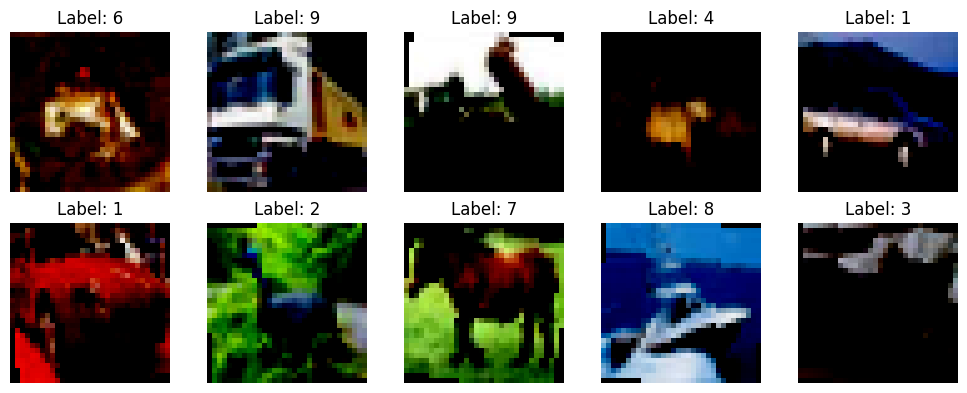

In [3]:
# Проверка корректности загрузки данных
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


train_images, train_labels = zip(*[(train_dataset[i][0], train_dataset[i][1]) for i in range(10)])
show_images(train_images, train_labels)

In [4]:
# Задание базовой архитектуры модели
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
# Создание модели
model = CNN()
print(model)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


In [6]:
epochs_time = 0

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    epoch_train_time = time.time() - start_time
    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    epochs_time += epoch_train_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy*100:.2f}%, Epoch Time: {epoch_train_time:.2f} seconds")
print(f"Total epochs time: {epochs_time:.4f}")

Epoch 1/10, Loss: 1.4940, Accuracy: 47.83%, Epoch Time: 13.44 seconds
Epoch 2/10, Loss: 0.9987, Accuracy: 64.95%, Epoch Time: 10.66 seconds
Epoch 3/10, Loss: 0.8560, Accuracy: 70.30%, Epoch Time: 10.31 seconds
Epoch 4/10, Loss: 0.7767, Accuracy: 72.99%, Epoch Time: 11.32 seconds
Epoch 5/10, Loss: 0.7167, Accuracy: 75.20%, Epoch Time: 11.09 seconds
Epoch 6/10, Loss: 0.6608, Accuracy: 77.31%, Epoch Time: 11.18 seconds
Epoch 7/10, Loss: 0.6260, Accuracy: 78.25%, Epoch Time: 11.67 seconds
Epoch 8/10, Loss: 0.5868, Accuracy: 79.65%, Epoch Time: 12.98 seconds
Epoch 9/10, Loss: 0.5656, Accuracy: 80.64%, Epoch Time: 13.71 seconds
Epoch 10/10, Loss: 0.5292, Accuracy: 81.77%, Epoch Time: 13.78 seconds
Total epoch time: 120.1426


In [7]:
# Вычисление значения loss и accuracy на тестовом наборе данных
model.eval()
total_loss = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

average_loss = total_loss / len(test_loader)
accuracy = total_correct / total_samples

print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

# Построение графиков loss и accuracy
epochs = range(1, num_epochs + 1)

Test Loss: 0.7541, Test Accuracy: 74.44%
